In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Piecewise Linear Interoplation (Interpolation Code 0)



## The Single Bin Case

In [3]:
def interpolate(down,nom,up,alpha):
    delta_up = up - nom
    delta_down = nom - down
    if alpha > 0:
        return delta_up*alpha
    else:
        return delta_down*alpha

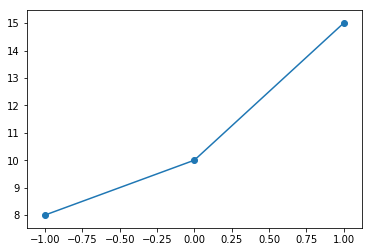

In [4]:
down_1,nom_1,up_1 = 8,10,15

alphas = np.linspace(-1.,1.)
interpolated_deltas = [interpolate(down_1,nom_1,up_1,alpha) for alpha in alphas]


plt.plot(alphas,[nom_1+delta for delta in interpolated_deltas])
plt.scatter((-1,0,1),(down_1,nom_1,up_1))

## Multi-bin Case (interpolating a logical Histogram from three Measurements)

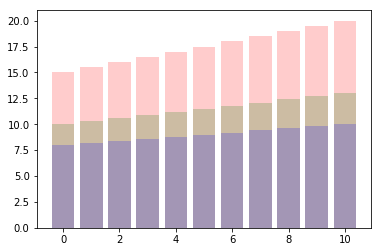

In [5]:
histogram_down = np.linspace(8,10,11)
histogram_nom = np.linspace(10,13,11)
histogram_up = np.linspace(15,20,11)

bincenters = np.arange(len(histogram_nom))
for c,h in zip(['r','g','b'],[histogram_up,histogram_nom,histogram_down]):
    plt.bar(bincenters,h, alpha = 0.2, facecolor = c)

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### At a single alpha value alpha = 0.5

In [10]:
histogram_down = np.linspace(8,10,11)
histogram_nom = np.linspace(10,13,11)
histogram_up = np.linspace(15,20,11)


from ipywidgets import interact

def plot_interpolated_histogram(alpha):
    interpolated = [nom + interpolate(dn,nom,up,alpha) for dn,nom,up in zip(histogram_down,histogram_nom,histogram_up)]
    bincenters = np.arange(len(interpolated))
    for c,h in zip(['k','#222222','#444444'],[histogram_up,histogram_nom,histogram_down]):
        plt.bar(bincenters,h, alpha = 0.2, facecolor = c)
    plt.bar(bincenters,interpolated, facecolor = 'r', alpha = 0.2)

x = interact(plot_interpolated_histogram,alpha = (-1,1))

interactive(children=(IntSlider(value=0, description='alpha', max=1, min=-1), Output()), _dom_classes=('widget…

### At a multiple alpha values alpha = [-1,....,1]

In [11]:
alphas = np.linspace(-1,1,11)

at_alphas = []

for alpha in alphas:
    inerpolated_hist = [nom + interpolate(dn,nom,up,alpha) for dn,nom,up in zip(histogram_down,histogram_nom,histogram_up)]
    at_alphas.append(inerpolated_hist)

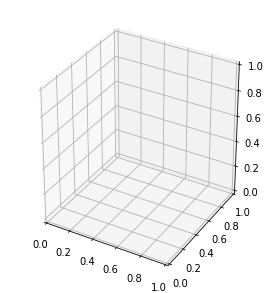

interactive(children=(IntSlider(value=2, description='index', max=5), Output()), _dom_classes=('widget-interac…

<function __main__.plot_wire(index)>

In [28]:
# setup the figure and axes

# fake data
x,y = np.meshgrid(bincenters,alphas)

top = np.asarray(at_alphas).ravel()
bottom = np.zeros_like(top)
width = depth = 1
def plot_wire(index):
    ax1.plot_wireframe(x, y,top.reshape(len(bincenters),len(alphas)), alpha = 0.3)
    ax1.plot_wireframe(x[4:5], y[4:5],top.reshape(len(bincenters),len(alphas))[4:5], edgecolor = 'r')
    ax1.set_zlim(0,25)
    ax1.view_init(azim=-125)
    plt.show()
interact(plot_wire,index = (0,5))